In [1]:
# Python 3.10.11

import numpy as np # v. 1.22.1
from matplotlib import pyplot as plt # v. 3.7.5
from matplotlib.ticker import AutoMinorLocator
import os
import pandas as pd # v. 1.5.3
import seaborn as sns # v. 0.12.2
import pykrev as pk # v. 1.2.4
import datetime

import sys
sys.path.append('../../mchem_functions/')
import ms_functions_and_defs as msf

from corems.transient.input.brukerSolarix import ReadBrukerSolarix # v. 1.6.0
from corems.encapsulation.factory.parameters import MSParameters
from corems.mass_spectrum.calc.Calibration import MzDomainCalibration
from corems.molecular_id.search.molecularFormulaSearch import SearchMolecularFormulas

The directory tree is organised as follows:

<img src="dir_tree_&_workflow.png" />

For the code to work, please modify the variable ```general_dir``` so as to direct the code towards the desired folder.

In [2]:
# Specify the folder where the MS data is, with the directory tree shown above.
filepath = '../../../Data/MS_data/ms_files/MP-HM-PW-D-24-02-2025_i_14-03-2025_000001.d' #'../../MS_data/dummy_31-10-2024'


In [3]:
# Declare folder db where the molformulas.sqlite file will be created and stored.
db = r'C:\db'
if not os.path.exists(db): os.mkdir(db)

In [4]:
def read_params(file_name:str,sep='\n---\n',comment='#'):
    '''
    You can use the read_params function to read in the parameters needed to process MS spectra of organic matter.
    The parameter file takes the following shape:

    ELEMENTAL PARAMETERS:
        C: 1, 100
        H: 1, 200
        O: 0, 26
    ---
    DBE: 0, 50
    ---
    PPM ERROR: 1
    ---
    MODE: -
    ---
    NOISE THRESHOLD STD: 3
    ---
    CALIB PPM THRESHOLD:
    31/10/2024: -0.1, 2.7
    02/11/2024: 0.5, 2
    ---
    O/C: 0, 1.2
    ---
    H/C: 0.3, 2.5
    ---

    Where "\\n---\\n" is the default separator.
    You can comment out sections by adding "#" at the beginning of the line, though you can also change this by setting the variable comment to something else.
    As such, make sure that file_name is a string of literals

    '''

    assert type(file_name) == str, 'The variable file_name must be a string of literals'
    assert type(sep) == str, 'The variable sep must be a string of literals'
    assert type(comment) == str, 'The variable comment must be a string of literals'

    def is_not_comment(str:str,comment:str):
        return not (str.startswith(comment) or str.startswith('\t'+comment))

    param_file = open(file_name, "r").read().split(sep)


    elem_dic = {}
    elem_ratios_dict = {}

    for p in param_file:
        if is_not_comment(p,comment):
            p = p.upper()
            if 'ELEMENTAL PARAMETERS' in p:
                elem_lim = p.replace(' ','').replace('ELEMENTALPARAMETERS','').replace('\t','').replace(':\n','').split('\n')
                for lim in elem_lim:
                    if is_not_comment(lim,comment):
                        lim = lim.split(':')
                        lims = lim[1].split(',')
                        lims = np.array(lims).astype(int)
                        lim_tuple = (int(np.min(lims)),int(np.max(lims)))
                        elem_dic[lim[0]] = lim_tuple

            elif 'DBE' in p:
                dbe_txt = p.replace('DBE:','').replace(' ','')
                dbe_txt = dbe_txt.split(',')
                dbe_txt = np.array(dbe_txt).astype(int)
                dbe = (int(np.min(dbe_txt)),int(np.max(dbe_txt)))

            elif 'PPM ERROR:' in p:
                ppm_error_txt = p.replace('PPM ERROR:','').replace(' ','')
                ppm_error = float(ppm_error_txt)

            elif 'MODE:' in p:
                mode_txt = p.replace('MODE:','').replace(' ','')
                if mode_txt.lower() in ['+','pos','positive','0']:
                    mode = False
                elif mode_txt.lower() in ['-','neg','negative','1']:
                    mode = True

            elif 'H/C:' in p:
                hc_txt = p.replace('H/C:','').replace(' ','')
                hc_txt = hc_txt.split(',')
                hc_txt = np.array(hc_txt).astype(float)
                elem_ratios_dict['H/C'] = (float(np.min(hc_txt)),float(np.max(hc_txt)))
            
            elif 'O/C:' in p:
                oc_txt = p.replace('O/C:','').replace(' ','')
                oc_txt = oc_txt.split(',')
                oc_txt = np.array(oc_txt).astype(float)
                elem_ratios_dict['O/C'] = (float(np.min(oc_txt)),float(np.max(oc_txt)))

            elif 'N/C:' in p:
                nc_txt = p.replace('N/C:','').replace(' ','')
                nc_txt = nc_txt.split(',')
                nc_txt = np.array(nc_txt).astype(float)
                elem_ratios_dict['N/C'] = (float(np.min(nc_txt)),float(np.max(nc_txt)))

            elif 'NOISE THRESHOLD STD:' in p:
                noise_threshold_std_txt = p.replace('NOISE THRESHOLD STD:','').replace(' ','')
                noise_threshold_std = float(noise_threshold_std_txt)

            elif 'CALIB PPM THRESHOLD:' in p:
                if '\n' not in p:
                    calib_ppm_error_threshold_txt = p.replace('CALIB PPM THRESHOLD:','').replace(' ','')
                    calib_ppm_error_threshold_txt = calib_ppm_error_threshold_txt.split(',')
                    for i in range(len(calib_ppm_error_threshold_txt)):
                            calib_ppm_error_threshold_txt[i] = float(calib_ppm_error_threshold_txt[i])
                    calib_ppm_error_threshold = (np.min(calib_ppm_error_threshold_txt),np.max(calib_ppm_error_threshold_txt))

                else:
                    calib_ppm_error_threshold = {}
                    calib_ppm_error_threshold_txt = p.replace('CALIB PPM THRESHOLD:\n','').replace(' ','')

                    calib_ppm_error_threshold_txt_split = calib_ppm_error_threshold_txt.split('\n')

                    for txt in calib_ppm_error_threshold_txt_split:
                        if is_not_comment(txt,comment):
                            txt = txt.split(':')
                            date = txt[0]

                            thresholds = txt[1].split(',')
                            thresholds = np.array(thresholds).astype(float)
                            thresholds_tuple = (float(np.min(thresholds)),float(np.max(thresholds)))
                            calib_ppm_error_threshold[date] = thresholds_tuple

    return elem_dic,elem_ratios_dict,dbe,ppm_error,mode,noise_threshold_std,calib_ppm_error_threshold

In [5]:
elem_dic,elem_ratios_dict,dbe,ppm_error,mode,noise_threshold_std,calib_ppm_error_threshold = read_params('parameters.txt')


In [6]:
def read_spectrum(file_path:str):
    '''
    Input the path to the ".d" directory with the Bruker Solarix mass spectral data in it and the corresponding mass spectrum object.

    Have a look at https://github.com/Kzra/pykrev/tree/master/docs/corems_with_pykrev by Dr Ezra Kitson for a tutorial example.
    '''

    bruker_reader = ReadBrukerSolarix(file_path)
    bruker_transient = bruker_reader.get_transient()
    mass_spectrum = bruker_transient.get_mass_spectrum(plot_result=False, auto_process = True)

    return mass_spectrum

def calibrate(mass_spectrum,ref_file_location:str,calib_ppm_error_threshold:tuple|list|np.ndarray,order=2):
    '''
    Calibrate a mass spectrum using a reference file and a ppm error threshold.

    Have a look at https://github.com/Kzra/pykrev/tree/master/docs/corems_with_pykrev by Dr Ezra Kitson for a tutorial example.
    '''
    #intialise internal calibration function
    calfn = MzDomainCalibration(mass_spectrum,ref_file_location)
    #read reference mass list in Python
    ref_mass_list_fmt  = calfn.load_ref_mass_list(ref_file_location)
    #pair up calibration points with detected peaks
    imzmeas, mzrefs = calfn.find_calibration_points(mass_spectrum, ref_mass_list_fmt,
                                                    calib_ppm_error_threshold=calib_ppm_error_threshold,
                                                    calib_snr_threshold=10)
    #perform the calibration using a second degree polynomial fit
    calfn.recalibrate_mass_spectrum(mass_spectrum,imzmeas,mzrefs,order=order)

    # MSParameters.mass_spectrum.min_calib_ppm_error = np.min(calib_ppm_error_threshold)
    # MSParameters.mass_spectrum.max_calib_ppm_error = np.max(calib_ppm_error_threshold)
    # MSParameters.mass_spectrum.calib_pol_order = 2 #This parameter only allows 1 (linear) or 2 (quadratic) but no higher polynomial fits
    # MzDomainCalibration(mass_spectrum, ref_file_location).run()

def noise_filter(mass_spectrum):
    '''
    Filter out electronic noise from the spectrum using the KMD method.

    Have a look at https://github.com/Kzra/pykrev/tree/master/docs/corems_with_pykrev by Dr Ezra Kitson for a tutorial example.
    '''
    km = mass_spectrum.kendrick_mass
    kmd = mass_spectrum.kmd

    lower = 0.0011232 * km + 0.05
    upper = 0.0011232 * km + 0.2
            
    llimit = kmd <= lower 
    ulimit = kmd >= upper 

    noiseWindow = (llimit + ulimit) !=True

    print(f"There are {sum(noiseWindow)} peaks in the noise window.")

    if sum(noiseWindow) >= 100: 
        nnPercentile = np.percentile(mass_spectrum.abundance[noiseWindow], q = 99) #find intensity matching to 99th percentile (i.e. only 1 % of peaks in noise window have higher intensity than this)
        plimit = mass_spectrum.abundance < nnPercentile #find peaks in the spectrum that have a lower intensity than this (returns a boolean array)
        filterIndex = np.where(plimit & noiseWindow)[0] #find the index position of peaks in spectrum that have both a lower intensity than the 99th percentile AND are in the noise window
        mass_spectrum.filter_by_index(filterIndex) #remove them from the spectrum

    print(f"There are {len(mass_spectrum.mz_exp)} peaks in the filtered spectrum.")

def peak_assignment(mass_spectrum,db:str,sqlite_file='molformulas.sqlite'):
    if 'molformulas.sqlite' in os.listdir(db):
        os.remove(f'{db}/{sqlite_file}')

    SearchMolecularFormulas(mass_spectrum, first_hit = False).run_worker_mass_spectrum()
    ass_txt = mass_spectrum.percentile_assigned(report_error=True)
    return ass_txt

def dbe_plot(mz:tuple|list|np.ndarray,dbe:tuple|list|np.ndarray,width:float=None,title:str=None):
    '''
    
    '''
    fig, ax = plt.subplots()
    ax.bar(mz,dbe,width = width)
    ax.set_title(title)
    ax.set_xlabel('m/z')
    ax.set_ylabel('DBE')
    return fig, ax

def massspectrum_plot(mz:tuple|list|np.ndarray,intensities:tuple|list|np.ndarray,title:str=None):
    fig, ax = plt.subplots()
    ax.plot(mz,intensities)
    ax.set_title(title)
    ax.set_xlabel('m/z')
    ax.set_ylabel('Intensity')
    ax.set_ylim(0)
    ax.set_xlim(np.min(mz),np.max(mz))
    return fig, ax

def blank_removal(blank_df:pd.core.frame.DataFrame,msDf:pd.core.frame.DataFrame):
    # blank_spectrum = read_spectrum(blank_path)

    # params(blank_spectrum,elem_dic,ppm_error)

    # peak_assignment(blank_spectrum,db)
    # blank_df = blank_spectrum.to_dataframe()

    assigned = blank_df['Molecular Formula'].notnull()
    blank_abundance = np.array(blank_df['Peak Height'][assigned])
    blank_formula = np.array(blank_df['Molecular Formula'][assigned])

    contaminants = blank_abundance / max(blank_abundance) * 100 > 2
    blank_formula = np.array(blank_formula)[contaminants]
    # Remove contaminant formula from dataframe 
    ccount = 0 
    for bf in blank_formula: 
        if bf in list(msDf['Molecular Formula']):
            ccount += 1 
            fidx = list(msDf['Molecular Formula']).index(bf)
            pidx = msDf.loc[fidx,'Index']
            didx = msDf[msDf['Index'] == pidx].index
            msDf.drop(index=didx)
    print(f"{ccount} contaminant formula removed")

def iteration_suffix(iteration,overall_len=6):
    iteration_str = str(iteration)
    return '0' * (overall_len-len(iteration_str)) + iteration_str

def give_associated_blank_name(replicate:str):
    '''
    Input the name of the blank replicate in the format "MeOH-H2O-BLK_[blank numer: 1, 2, 3, ...]_[replicate number: i, ii, iii, ...]_[DD]-[MM]-[YYYY]"
    and get the name of the blank without the replicate number.
    '''
    replicate = replicate.split('_')
    return '_'.join((replicate[0],replicate[1],replicate[-1]))

MSParameters.mass_spectrum.threshold_method = 'auto'
MSParameters.mass_spectrum.noise_threshold_std = noise_threshold_std
MSParameters.ms_peak.peak_min_prominence_percent = .01

# mass_spectrum.threshold_method = 'log'
# mass_spectrum.log_nsigma = 10
# mass_spectrum.log_nsigma_bins = 500

MSParameters.ms_peak.kendrick_rounding_method = 'ceil' #Round up in kmd calculations


MSParameters.mass_spectrum.threshold_method = 'auto'
MSParameters.mass_spectrum.noise_threshold_std = noise_threshold_std
MSParameters.ms_peak.peak_min_prominence_percent = 0.01
MSParameters.ms_peak.kendrick_rounding_method = 'ceil' #Round up in kmd calculations

MSParameters.mass_spectrum.min_picking_mz  = 150
MSParameters.mass_spectrum.max_picking_mz  = 800
MSParameters.mass_spectrum.min_noise_mz = 150
MSParameters.mass_spectrum.max_noise_mz = 800

# Set the location of the molecular formulae database
MSParameters.molecular_search.url_database = None #set none if you aren't using the docker database

# Scoring
MSParameters.molecular_search.error_method = 'None' 
MSParameters.molecular_search.score_method = 'prob_score'

# DBE Limits
MSParameters.molecular_search.min_dbe = np.min(dbe)
MSParameters.molecular_search.max_dbe = np.max(dbe)

# Isotopologue filter
MSParameters.molecular_search.use_isotopologue_filter = True
MSParameters.molecular_search.min_abun_error = -30
MSParameters.molecular_search.max_abun_error = 70

# Mininimum peaks-per-class 
MSParameters.molecular_search.use_min_peaks_filter = False
# molecular_search.min_peaks_per_class = False

# O/C, H/C, and N/C filters:
if 'H/C' in elem_ratios_dict.keys():
    MSParameters.molecular_search.min_hc_filter = np.min(elem_ratios_dict['H/C'])
    MSParameters.molecular_search.max_hc_filter = np.max(elem_ratios_dict['H/C'])
if 'O/C' in elem_ratios_dict.keys():
    MSParameters.molecular_search.min_oc_filter = np.min(elem_ratios_dict['O/C'])
    MSParameters.molecular_search.max_oc_filter = np.max(elem_ratios_dict['O/C'])
if 'N/C' in elem_ratios_dict.keys() and 'N' in elem_dic.keys():
    MSParameters.molecular_search.min_nc_filter = np.min(elem_ratios_dict['N/C'])
    MSParameters.molecular_search.max_nc_filter = np.max(elem_ratios_dict['N/C'])

# Elements defined and their limits
for e in elem_dic:
    MSParameters.molecular_search.usedAtoms[e] = elem_dic[e]

# mass error limits 
MSParameters.molecular_search.min_ppm_error = -5
MSParameters.molecular_search.max_ppm_error = 5

# ion type
MSParameters.molecular_search.isProtonated = mode
MSParameters.molecular_search.isRadical = False
MSParameters.molecular_search.isAdduct = False

def process_spectra(spectra_files:tuple|list|np.ndarray,calib_ppm_error_threshold:tuple|list|np.ndarray,**kwargs):
    '''
    Batch process raw mass spectra into more easily accessible CSV files.

    Have a look at https://github.com/Kzra/pykrev/tree/master/docs/corems_with_pykrev by Dr Ezra Kitson for a tutorial example.
    '''
    
    for file in spectra_files:
        print(f'---------Starting to process {file}---------')

        # 1 - Read the spectrum and get mass spectrum object
        mass_spectrum = read_spectrum(file)

        # Initialise the search parameters that will be used
      
        # 2 - Remove electronic noise
   
        noise_filter(mass_spectrum)

        # 3 - Calibrate the spectrum based on a reference file
        print(f'---------Calibration for {file}-------------')
        calibrate(mass_spectrum,'Hawkes_neg.ref',calib_ppm_error_threshold)
        titles = 'Calibrated'

        print(f"There are {len(mass_spectrum)} peaks in the {titles} spectrum of {file}")
        
        # 4 - Assign peaks to molecular formulas based on the chosen parameters.
        ass_txt = peak_assignment(mass_spectrum,db)

        # logs = kwargs.get('logs', False)
        
        msDf = mass_spectrum.to_dataframe()

        # # Plot the mass spectrum
        # fig_spectrum, ax_spectrum = msf.massspectrum_plot(msDf['m/z'],msDf['Peak Height'],title=f'{titles} Mass Spectrum of {file}')

        #Plot the error jointplot
        jointplot = sns.jointplot(x='m/z', y='m/z Error (ppm)', data = msDf)
        jointplot.fig.suptitle(f"Error Jointplot of {file}")

        # Plot a van Krevelen diagram and a DBE diagram.

        fig_vk, ax_vk = plt.subplots()
        ax_vk.scatter(msDf['O/C'],msDf['H/C'],marker='.',s=5)
        ax_vk.set_xlim(0)

        # Save the resulting dataframe into a CSV file

        print(f'---------Finished processing {file}---------\n')

        return msDf

def add_ticks(ax,axis,mult=.2,no_of_minorticks=1):
    if axis == 'x':
        ax_set_ticks = ax.set_xticks
        lims = ax.get_xlim()
        lims_range = np.max(lims)-np.min(lims)
        set_minor_ticks = ax.xaxis.set_minor_locator
    elif axis == 'y':
        ax_set_ticks = ax.set_yticks
        lims = ax.get_ylim()
        lims_range = np.max(lims)-np.min(lims)
        set_minor_ticks = ax.yaxis.set_minor_locator

    step = mult*lims_range
    major_ticks = np.arange(np.min(lims),np.max(lims)+step*.2,step)
    ax_set_ticks(major_ticks)
    set_minor_ticks(AutoMinorLocator(no_of_minorticks+1))

---------Starting to process ../../../Data/MS_data/ms_files/MP-HM-PW-D-24-02-2025_i_14-03-2025_000001.d---------
There are 0 peaks in the noise window.
There are 9983 peaks in the filtered spectrum.
---------Calibration for ../../../Data/MS_data/ms_files/MP-HM-PW-D-24-02-2025_i_14-03-2025_000001.d-------------
MS Obj loaded - 9983 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
580 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.387 ppm
minimize function performed 303 fn evals and 6 iterations
There are 9983 peaks in the Calibrated spectrum of ../../../Data/MS_data/ms_files/MP-HM-PW-D-24-02-2025_i_14-03-2025_000001.d
'runworker'  15.67 ms


Loading molecular formula database: 79342it [00:03, 24055.50it/s]
Started molecular formula search for class {"O": 40}, (de)protonated : 100%|██████████| 41/41 [00:03<00:00, 10.67it/s]


'run_molecular_formula'  7182.14 ms
6192 assigned peaks and 3791 unassigned peaks, total  = 62.03 %, relative abundance = 77.78 %, RMS error (best candidate) (ppm) = 1.848
---------Finished processing ../../../Data/MS_data/ms_files/MP-HM-PW-D-24-02-2025_i_14-03-2025_000001.d---------



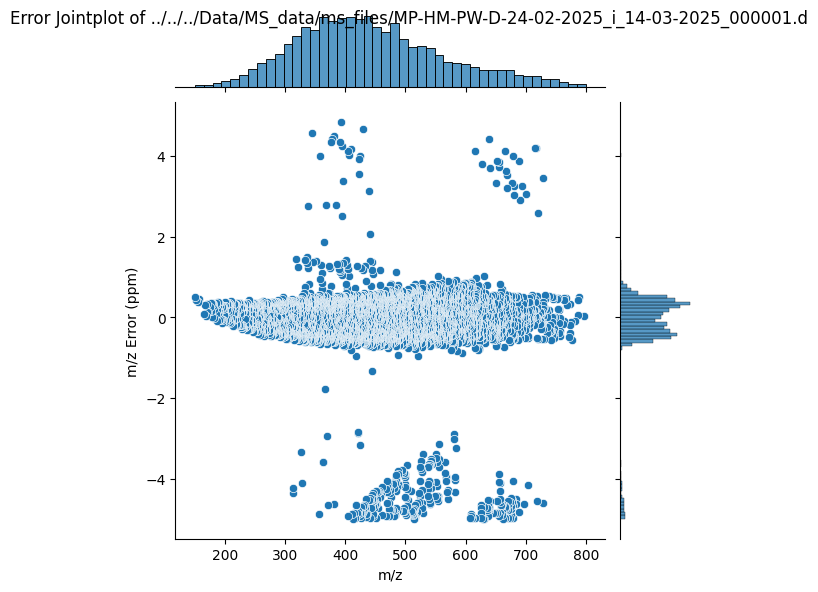

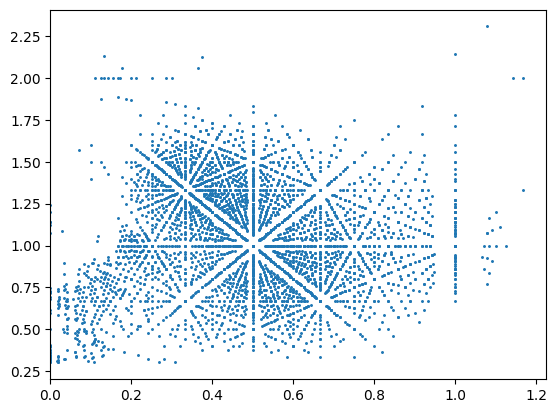

In [7]:
msDf = process_spectra([filepath],calib_ppm_error_threshold=calib_ppm_error_threshold)

In [7]:
mass_spectrum = read_spectrum(filepath)

In [8]:
noise_filter(mass_spectrum)
calibrate(mass_spectrum,'Hawkes_neg.ref',calib_ppm_error_threshold)

There are 0 peaks in the noise window.
There are 9983 peaks in the filtered spectrum.
MS Obj loaded - 9983 peaks found.
Reference mass list loaded - 2030 calibration masses loaded.
580 calibration points matched within thresholds.
minimize function completed with RMS error of: 0.387 ppm
minimize function performed 303 fn evals and 6 iterations


In [9]:
peak_assignment(mass_spectrum,db)

'runworker'  8.80 ms


Loading molecular formula database: 79342it [00:03, 25443.51it/s]
Started molecular formula search for class {"O": 40}, (de)protonated : 100%|██████████| 41/41 [00:03<00:00, 12.17it/s]


'run_molecular_formula'  6597.99 ms
6192 assigned peaks and 3791 unassigned peaks, total  = 62.03 %, relative abundance = 77.78 %, RMS error (best candidate) (ppm) = 1.848


(6192, 3791, 62.025443253531, 77.78309480370193, 1.8476084961510701)

In [11]:
msDf = mass_spectrum.to_dataframe()

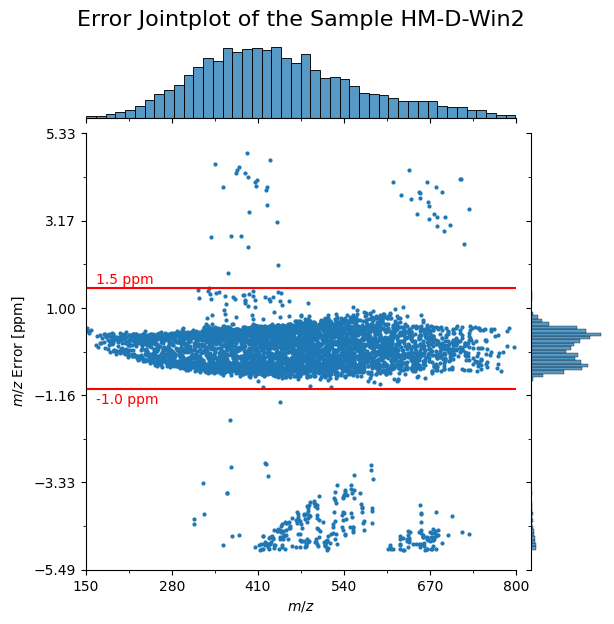

In [12]:
jointplot = sns.jointplot(x='m/z', y='m/z Error (ppm)', data = msDf,linewidth=0,marker='.')

fig_jp = plt.gcf()
ax_jp = plt.gca()

ax_jp.set_xlabel('$m$/$z$')
ax_jp.set_ylabel('$m$/$z$ Error [ppm]')

ax_jp.set_xlim(150,800)

ax_jp.text(np.mean((ax_jp.get_xlim())),np.max(ax_jp.get_ylim())*1.5,
           f"Error Jointplot of the Sample HM-D-Win2",fontsize=16,
           ha='center')
ppm_threshold_try = (-1,1.5)
ax_jp.axhline(np.min(ppm_threshold_try),c='r')
xlim = ax_jp.get_xlim()
ylim_avg = np.mean(ax_jp.get_ylim())
ypadding = 0.1
ax_jp.text(np.min(xlim)+15,np.min(ppm_threshold_try)-ypadding,f'{np.min(ppm_threshold_try)} ppm',color='r',va='top')
ax_jp.axhline(np.max(ppm_threshold_try),c='r')
ax_jp.text(np.min(xlim)+15,np.max(ppm_threshold_try)+ypadding,f'{np.max(ppm_threshold_try)} ppm',color='r')
add_ticks(ax_jp,'x')
add_ticks(ax_jp,'y')
fig_jp.savefig('../../../Data/MS_data/plots/example_jointplot.svg',dpi = 600, facecolor = '#fff', bbox_inches='tight')

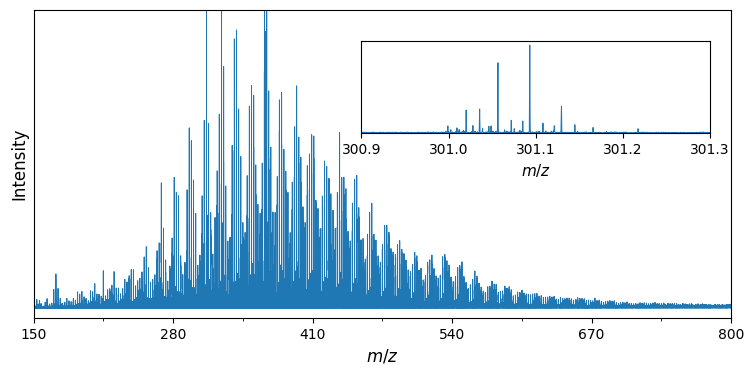

In [13]:
fig_ms,ax_ms = plt.subplots(figsize=(9,4))
intensity = mass_spectrum.abundance_profile
intensity /= np.max(intensity)
mz = mass_spectrum.mz_exp_profile

ax_ms.plot(mz,intensity,lw=.7)
ax_ms.set_yticks([])
ax_ms.set_xlim(150,800)
ax_ms.set_ylim(-.005,.15)
ax_ms.set_xlabel('$m$/$z$',fontsize=12)
ax_ms.set_ylabel('Intensity',fontsize=12)
# ax_ms.set_title('Mass Spectrum of the Sample HM-D-Win2',fontsize=18)

x1, x2, y1, y2 = 300.9,301.3,0,.05  # subregion of the original image
axins = ax_ms.inset_axes(
    [.47, 0.6, 0.5, 0.3],
    xlim=(x1, x2), ylim=(y1, y2),yticklabels=[],yticks=[])
axins.plot(mz,intensity,lw=.7)

axins.set_xlabel('$m$/$z$',fontsize=11)
add_ticks(ax_ms,'x')
fig_ms.savefig('../../../Data/MS_data/plots/example_ms.svg',dpi = 600, facecolor = '#fff', bbox_inches='tight')

In [13]:
decon90 = ['C6 H9 O9',
'C6 H15 NO3',
'C18 H30 O3 S1',
'C12 H26 O1']

In [14]:
msDf = msDf[~msDf['Molecular Formula'].isin(decon90)]

In [ ]:
msDf[msDf['Peak Height']==np.max(msDf['Peak Height'])]

,Index,m/z,Calibrated m/z,Calculated m/z,Peak Height,Resolving Power,S/N,Ion Charge,m/z Error (ppm),m/z Error Score,...,Heteroatom Class,Ion Type,Is Isotopologue,Mono Isotopic Index,Molecular Formula,C,H,O,13C,18O
13170,12789,325.184384,325.184192,NaN,4.916208e+09,633862.016561,8724.996362,-1,NaN,NaN,...,unassigned,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df = pd.read_csv(r'C:\Users\s2017658\OneDrive - University of Edinburgh\Y5\Data\MS_data\CSV_files\MP-HM-PW-G-17-10-2024-OM_i_08-11-2024_000001.csv')

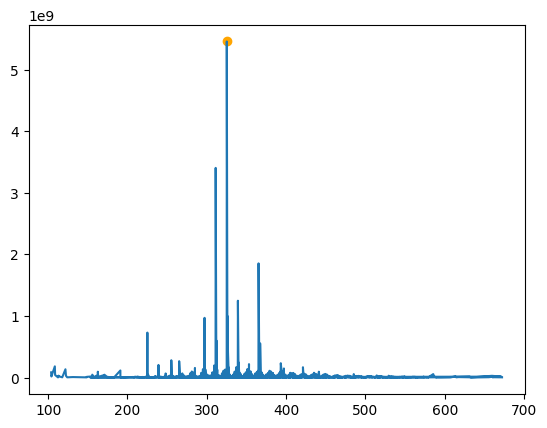

In [ ]:
plt.plot(df['m/z'],df['Peak Height'])
plt.scatter(df['m/z'][df['Molecular Formula']=='C18 H30 O3 S1'],df['Peak Height'][df['Molecular Formula']=='C18 H30 O3 S1'],c='orange')